# Quicksort and dirty
In this example we will read the files sounds are found in the **data.tar.zg (C6436)** files and extract two descriptors to form a dataframe then join this table with the reference table which contains the information of the samples

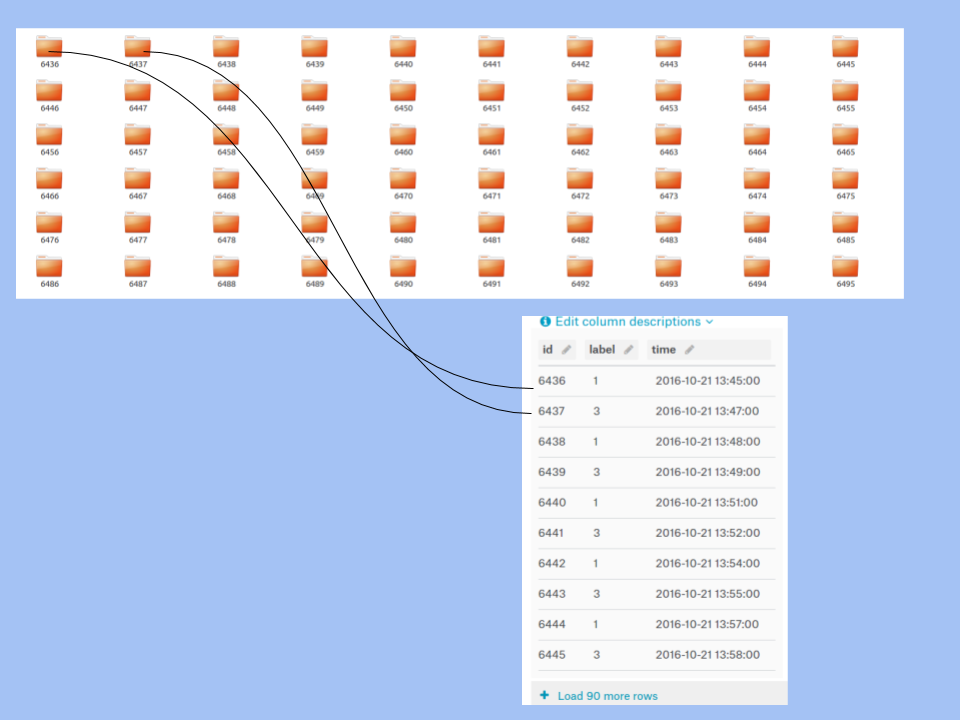

In [51]:
from IPython.display import Image
Image(filename='join_sample.png')

In [ ]:
import tarfile 
import numpy as _np 
import wave
import os
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

## Read a wave file in 24 bit resolution
Normally I use the wavio module to open files in 24 bits, but this module is not included on kaggle. I therefore used the functions of the module

In [ ]:
#https://github.com/WarrenWeckesser/wavio/blob/master/wavio.py

def _wav2array(nchannels, sampwidth, data):
    """data must be the string containing the bytes from the wav file."""
    num_samples, remainder = divmod(len(data), sampwidth * nchannels)
    if remainder > 0:
        raise ValueError('The length of data is not a multiple of '
                         'sampwidth * num_channels.')
    if sampwidth > 4:
        raise ValueError("sampwidth must not be greater than 4.")

    if sampwidth == 3:
        a = _np.empty((num_samples, nchannels, 4), dtype=_np.uint8)
        raw_bytes = _np.fromstring(data, dtype=_np.uint8)
        a[:, :, :sampwidth] = raw_bytes.reshape(-1, nchannels, sampwidth)
        a[:, :, sampwidth:] = (a[:, :, sampwidth - 1:sampwidth] >> 7) * 255
        result = a.view('<i4').reshape(a.shape[:-1])
    else:
        # 8 bit samples are stored as unsigned ints; others as signed ints.
        dt_char = 'u' if sampwidth == 1 else 'i'
        a = _np.fromstring(data, dtype='<%s%d' % (dt_char, sampwidth))
        result = a.reshape(-1, nchannels)
    return result
class Wav(object):
 

    def __init__(self, data, rate, sampwidth):
        self.data = data
        self.rate = rate
        self.sampwidth = sampwidth

#    def __repr__(self):
#        s = ("Wav(data.shape=%s, data.dtype=%s, rate=%r, sampwidth=%r)" %
#             (self.data.shape, self.data.dtype, self.rate, self.sampwidth))
#        return s
def read(file):

    wav = wave.open(file)
    rate = wav.getframerate()
    nchannels = wav.getnchannels()
    sampwidth = wav.getsampwidth()
    nframes = wav.getnframes()
    data = wav.readframes(nframes)
    wav.close()
    array = _wav2array(nchannels, sampwidth, data)
    w = Wav(data=array, rate=rate, sampwidth=sampwidth)
    return w

# Feature extraction
For all samples, we extract the entropy and the standard deviation to create simple dataframe with the label of the samples and their id

In [ ]:
def Entropy(root,df):
        #array containing all descriptors for all samples
        resuls=list()
        with tarfile.open(root) as tar :
        #list file in data.tar
          for member in tar.getnames() :
        #Taking just the wave files      
            if member.endswith(".wav"):
        #read wave file with the Read fonction
                      wav=read(tar.extractfile(member))
        #array containing all descripton for each sample
                      resul=[]
        #The id is the sample number, which is also the subfolder name of C6436 in data.tar.zg
                      id=os.path.basename( os.path.dirname(member))
        #sound stereo
                      left,right=wav.data[:,0],wav.data[:,1]
        #hanning wondow
                      hann = np.hanning(len(left))
        #fft
                      l,f=np.abs(np.fft.fft(left*hann)), np.fft.rfft(right)
                      std=np.std(l)
                      entropy=stats.entropy(l)
                      resul.append(entropy)
                      resul.append(std)
                      resul=np.append(resul,int(id))
                      resuls.append(resul)
        #create dataframe and join
        df=pd.DataFrame(columns= ["Hf","std","id"],index=xrange(len(resuls)))
        for row in xrange(len(resuls)):
                df.ix[row]=resuls[row] 
        df=pd.merge(df,df2,on="id",how="right")  
        return df

In [40]:
df2=pd.read_csv("reference.csv")
df2.head()

,id,label,time
0,6436,1,2016-10-21 13:45:00
1,6437,3,2016-10-21 13:47:00
2,6438,1,2016-10-21 13:48:00
3,6439,3,2016-10-21 13:49:00
4,6440,1,2016-10-21 13:51:00


In [48]:
df=Entropy("data.tar.gz",df2)
df.head()

,Hf,std,id,label,time
0,9.98477,2.18493e+09,6470,1,2016-10-21 14:40:00
1,12.0729,2.18379e+09,6491,3,2016-10-21 15:11:00
2,9.92023,2.18534e+09,6453,3,2016-10-21 14:10:00
3,9.95301,2.18493e+09,6474,1,2016-10-21 14:46:00
4,11.5429,2.1844e+09,6480,1,2016-10-21 14:55:00


In [49]:
sns.FacetGrid(df, hue="label", size=6) \
   .map(sns.kdeplot, "std") \
   .add_legend()
plt.show() 

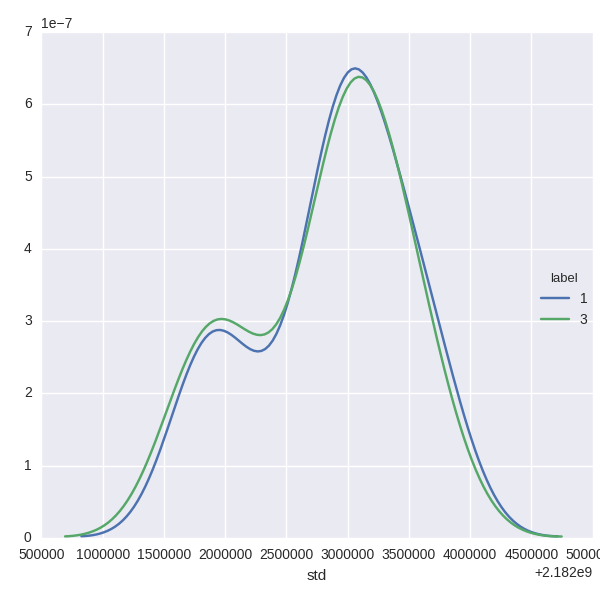

In [50]:
from IPython.display import Image
Image(filename='figure1.png')